# **SETUP AND INSTALLATIONS**

In [1]:
# !pip install -q fastbook

In [2]:
#To upload the Kaggle.json file
# from google.colab import files
# files.upload()

# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d ashokpant/devanagari-character-dataset

In [3]:
# !unzip -q devanagari-character-dataset.zip
# !mkdir data
# !mv nhcd/nhcd/numerals/3 nhcd/nhcd/numerals/7 data/

# **PREMISE**

Check the influence of shuffle on model training

### IMPORTS

In [4]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(21)

### DATASET PREPARATION

Since we want to see the performance of model with and without shuffle, making separate validation sets for 3 and 7

In [6]:
all_three_files = get_image_files(Path("data/3"))
all_seven_files = get_image_files(Path("data/7"))

In [7]:
train_images = all_three_files[0:196] + all_seven_files[0:196]
valid_3_images = all_three_files[196:] 
valid_7_images = all_seven_files[196:]

In [8]:
def image_read(x): return tensor(Image.open(x))/255

train_tensors = torch.stack([image_read(x) for x in train_images])
valid_3_tensors = torch.stack([image_read(x) for x in valid_3_images])
valid_7_tensors = torch.stack([image_read(x) for x in valid_7_images])

train_tensors = train_tensors.view(-1, 28 * 28)
valid_3_tensors = valid_3_tensors.view(-1, 28 * 28)
valid_7_tensors = valid_7_tensors.view(-1, 28 * 28)

train_targets = torch.tensor([[1] if parent_label(x) == '3' else [0] for x in train_images])
valid_3_targets = torch.tensor([[1]]*len(valid_3_tensors))
valid_7_targets = torch.tensor([[0]]*len(valid_7_tensors))


train_dset = list(zip(train_tensors, train_targets))
valid_3_dset = list(zip(valid_3_tensors, valid_3_targets))
valid_7_dset = list(zip(valid_7_tensors, valid_7_targets))

### MODEL TRAINING - CUSTOM

In [9]:
def initialize_wandb(random_ = True):
    if random_:
        weights = torch.randn((28 * 28, 1)).requires_grad_()
    else:
        weights = train_tensors.mean(axis = 0).unsqueeze(1).requires_grad_()
    biases = torch.randn(1).requires_grad_()
    return(weights, biases)

def sigmoid(x):
    return 1. / (1. + torch.exp(x))

def forward(batch, w, b):
    return sigmoid(batch@w + b)

def rmse_loss(preds, targets):
    return ((preds - targets) ** 2).sum().mean()

In [10]:
def train_and_validate(weights, biases, nepochs = 100, bs = 64, lr = 1e-3, shuffle = False):
    # Create a dataloader for train and validation sets with given batch_size
    
    train_dl = DataLoader(train_dset, batch_size = bs, shuffle = shuffle)
    valid_3_dl = DataLoader(valid_3_dset, batch_size = bs, shuffle = shuffle)
    valid_7_dl = DataLoader(valid_7_dset, batch_size = bs, shuffle = shuffle)
    
    
    train_losses = []
    validation_3_losses = []
    validation_7_losses = []

    # Define the training loop
    for epoch in progress_bar(range(nepochs), comment = f"Training for {nepochs} epochs with batch size of {bs}"):
        losses = []
        for xb, yb in train_dl:
            # Forward pass
            predictions = forward(xb, weights, biases)
            
            # loss computation
            loss = rmse_loss(predictions, yb)
            
            # Gradient computation
            loss.backward()
            
            # Weight updation
            weights.data -= lr * weights.grad.data
            biases.data -= lr * biases.grad.data
            
            # Stop accumulation of gradients
            weights.grad = None
            biases.grad = None
            
            # Record the losses
            losses.append(loss.item())
            
        # Record all the train losses for this epoch 
        train_losses.append(losses)
      
        # Check the validation set loss
        with torch.no_grad():
            losses = []
            for xb, yb in valid_3_dl:
                # Forward pass
                predictions = forward(xb, weights, biases)
                
                # Loss computation
                loss = rmse_loss(predictions, yb)
                
                # Append the loss
                losses.append(loss.item())
            
            validation_3_losses.append(losses)

            losses = []
            for xb, yb in valid_7_dl:
                # Forward pass
                predictions = forward(xb, weights, biases)
                
                # Loss computation
                loss = rmse_loss(predictions, yb)
                
                # Append the loss
                losses.append(loss.item())
            validation_7_losses.append(losses)
        

    return (train_losses, validation_3_losses, validation_7_losses)

In [11]:
# Handy Plotter
  
def plot_loss(train, three, seven, shuffle):
    f = lambda x: [np.mean(y) for y in x]
    # plot lines
    plt.plot(f(train), label = "train")
    plt.plot(f(three), label = "three")
    plt.plot(f(seven), label = "seven")
    plt.title(shuffle)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#### **COMPARISIONS**

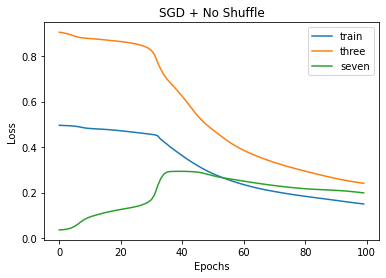

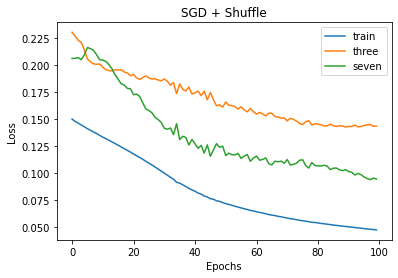

In [12]:
# Stochastic Gradient Descent
wts, bias = initialize_wandb(True)
# plt.plot(wSGD.detach().numpy())
# plt.show()
tlsSGD, vls3SGD, vls7SGD = train_and_validate(wts, bias , bs = 1, shuffle=False)
plot_loss(tlsSGD, vls3SGD, vls7SGD, "SGD + No Shuffle")
tlsSGD, vls3SGD, vls7SGD = train_and_validate(wts, bias , bs = 1, shuffle=True)
plot_loss(tlsSGD, vls3SGD, vls7SGD, "SGD + Shuffle")

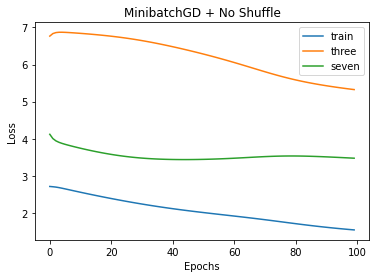

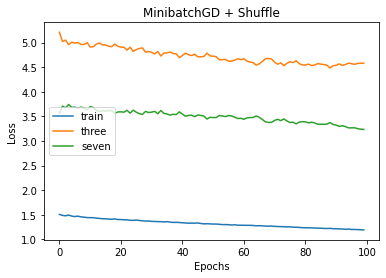

In [13]:
# Minibatch Gradient Descent
tlsMBSGD, vls3MBSGD, vls7MBSGD = train_and_validate(wts, bias , bs = 64, shuffle=False)
plot_loss(tlsMBSGD, vls3MBSGD, vls7MBSGD, "MinibatchGD + No Shuffle")
tlsMBSGD, vls3MBSGD, vls7MBSGD = train_and_validate(wts, bias , bs = 64, shuffle=True)
plot_loss(tlsMBSGD, vls3MBSGD, vls7MBSGD , "MinibatchGD + Shuffle")

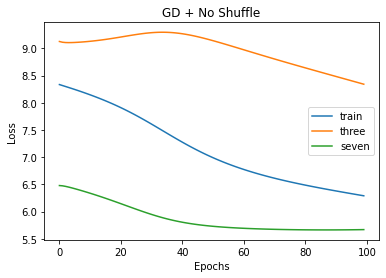

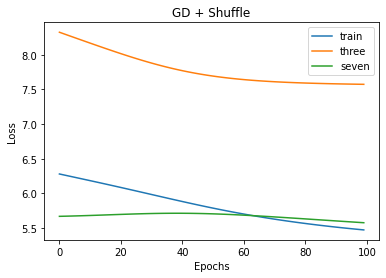

In [14]:
# Gradient Descent
tlsGD, vls3GD, vls7GD = train_and_validate(wts, bias , bs = len(train_dset), shuffle=False)
plot_loss(tlsGD, vls3GD, vls7GD, "GD + No Shuffle")
tlsGD, vls3GD, vls7GD = train_and_validate(wts, bias , bs = len(train_dset), shuffle=True)
plot_loss(tlsGD, vls3GD, vls7GD, "GD + Shuffle")

### MODEL TRAINING - PYTORCH

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return F.log_softmax(out)

input_size = 784 # 28x28
hidden_size = 500 
num_classes = 2
network = Net(input_size, hidden_size, num_classes)
optimizer = optim.SGD(network.parameters(), lr=1e-3)

In [20]:
def train_and_validate_net(nepochs = 100, bs = 64, shuffle = False):
    # Create a dataloader for train and validation sets with given batch_size
    
    train_dl = DataLoader(train_dset, batch_size = bs, shuffle = shuffle)
    valid_3_dl = DataLoader(valid_3_dset, batch_size = bs, shuffle = shuffle)
    valid_7_dl = DataLoader(valid_7_dset, batch_size = bs, shuffle = shuffle)
    
    
    train_losses = []
    validation_3_losses = []
    validation_7_losses = []
    lph = [0,0]

    # Define the training loop
    for epoch in progress_bar(range(nepochs), comment = f"Training for {nepochs} epochs with batch size of {bs}"):
        losses = []
        for xb, yb in train_dl:
            optimizer.zero_grad()
            # Forward pass
            predictions = network(xb)
            
            # loss computation
            loss = F.nll_loss(predictions, yb)

            
            # Gradient computation
            loss.backward()
            optimizer.step()
            
            # Record the losses
            losses.append(loss.item())
            
        # Record all the train losses for this epoch 
        train_losses.append(losses)
      
        # Check the validation set loss
        with torch.no_grad():
            losses = []
            for xb, yb in valid_3_dl:
                # Forward pass
                predictions = network(xb)
                
                # loss computation
                loss = F.nll_loss(predictions, yb[0])

                losses.append(loss.item())
            
            validation_3_losses.append(losses)

            losses = []
            for xb, yb in valid_7_dl:
                # Forward pass
                predictions = network(xb)
                
                # loss computation
                loss = F.nll_loss(predictions, yb[0])
                losses.append(loss.item())

            validation_7_losses.append(losses)
        

    return (train_losses, validation_3_losses, validation_7_losses)

#### **COMPARISIONS**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


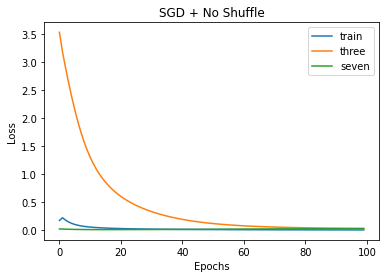

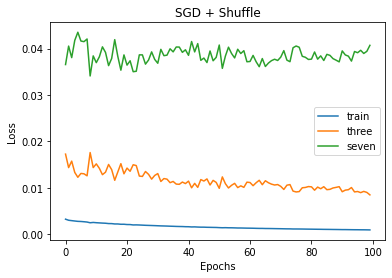

In [17]:
# Stochastic Gradient Descent
tlsSGD, vls3SGD, vls7SGD = train_and_validate_net(bs = 1, shuffle=False)
plot_loss(tlsSGD, vls3SGD, vls7SGD, "SGD + No Shuffle")
tlsSGD, vls3SGD, vls7SGD = train_and_validate_net(bs = 1, shuffle=True)
plot_loss(tlsSGD, vls3SGD, vls7SGD, "SGD + Shuffle")